In [0]:
######## >>>>>>>>>>> For the google colab to be able to access the meta files you must add the APS360 team shared folder to your drive by right clicking on it <<<<<<<<<<< ##############
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
# Prints how many nulls there are in max and min temp
def test_null_csv_daily(dir, station, start_year, end_year, out_name =  None):
    """
      Args:
          station (string): eg. "ON_6158355"
          start_year (int): Starting year
          end_year (int)  : Ending year
          start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
          out_name (optional string) : change the name of the output file
    """
    if out_name == None:
      out_name = station + '_' + str(start_year) + '-' + str(end_year)
    master_path = '/content/gdrive/My Drive/APS360 Team/milestone 3/' + dir
    src_path = master_path + 'datasets/'
    newdf = pd.read_csv(src_path + out_name + ".csv")
    print("Max temp nulls: " + str(newdf['Max Temp (°C)'].isnull().sum()))
    print("Min temp nulls: " + str(newdf['Min Temp (°C)'].isnull().sum()))

In [0]:
import pandas as pd
# Interpolates null values in min and max temp cols
def inter_nulls_csv_daily(dir, station, start_year, end_year, out_name =  None):
    """
      Args:
          station (string): eg. "ON_6158355"
          start_year (int): Starting year
          end_year (int)  : Ending year
          start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
          out_name (optional string) : change the name of the output file
    """
    if out_name == None:
      out_name = station + '_' + str(start_year) + '-' + str(end_year)
    master_path = '/content/gdrive/My Drive/APS360 Team/milestone 3/' + dir
    src_path = master_path + 'datasets/'
    newdf = pd.read_csv(src_path + out_name + ".csv")
    newdf['Max Temp (°C)'] = newdf['Max Temp (°C)'].interpolate()
    newdf['Min Temp (°C)']= newdf['Min Temp (°C)'].interpolate()
    newdf.to_csv( src_path +  out_name + ".csv")

In [0]:
#Raw csv downloaded must be place in /raw folder
#Merged csv will be stored at /datasets folder
# Also interpolates the null max and min temp
def make_csv_daily(dir, station, start_year, end_year, out_name =  None):
  """
    Args:
        station (string): eg. "ON_6158355"
        start_year (int): Starting year
        end_year (int)  : Ending year
        start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
        out_name (optional string) : change the name of the output file
    """
  if out_name == None:
    out_name = station + '_' + str(start_year) + '-' + str(end_year)
  master_path = '/content/gdrive/My Drive/APS360 Team/milestone 3/' + dir
  src_path = master_path
  dest_path = master_path + 'datasets/'
  fout = open(dest_path + out_name + ".csv","w+")
  in_base = "en_climate_daily_" + station + '_' #eg: 'en_climate_daily_ON_6158355_'
  in_end = '_P1D.csv'
  # first file:
  for line in open(src_path + in_base + str(start_year) + in_end):
      fout.write(line)
  # now the rest:    
  for num in range(start_year + 1, end_year + 1):
      f = open(src_path + in_base + str(num) + in_end)
      f.__next__() # skip the header
      for line in f:
          fout.write(line)
      f.close() # not really needed
  fout.close()
  inter_nulls_csv_daily(dir, station, start_year, end_year, out_name)

In [0]:
stationSurr = ["ON_615S001", "ON_6158751", "ON_615HMAK"]

In [0]:
##### run once #######
make_csv_daily(dir = "data/Target A/target/", station = "ON_6158355", start_year = 2008, end_year = 2014) # run once
make_csv_daily(dir = "data/Target A/surr/", station = stationSurr[0], start_year = 2008, end_year = 2014) # run once
make_csv_daily(dir = "data/Target A/surr/", station = stationSurr[1], start_year = 2008, end_year = 2014) # run once
make_csv_daily(dir = "data/Target A/surr/", station = stationSurr[2], start_year = 2008, end_year = 2014) # run once

In [0]:
import pandas as pd
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
set_num_attributes = 2
class WeatherSurroundingDataset(Dataset):
    """Weather dataset."""

    def __init__(self, dirSrc, dirSurr, stationSrc, stationSurr, start_year, end_year, start_date = 0, end_date = None, num_days = 7, make_csv = False, out_name = None):
        """
        Args:
            dirSrc (string) =  "data/Target A/target/" relative directory of target station
            dirSurr (string) = "data/Target A/surr/" relative directory of surrounding stations
            stationSrc (string): eg. "ON_6158355"
            stationSurr (list of strings)
            start_year (int): Starting year
            end_year (int)  : Ending year
            start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
            end_date (optional int) : end_date = 7 is day 8 of starting year(min = 7 because of LABEL!). If provided changes the end date from last day of last year.
            num_days (optional int) : num_days is the interval of days before the label.
            make_csv (optional bool): If true it will call make_csv_daily function to create the csv from /raw datasets into /datasets
            out_name (optional string) : change the name of the output file which it reads from
        """
        self.num_days = num_days
        if(out_name == None):
          self.out_name = stationSrc + '_' + str(start_year) + '-' + str(end_year)
        else:
          self.out_name = out_name
        master_path = '/content/gdrive/My Drive/APS360 Team/milestone 3/' +  dirSrc
        dest_path = master_path + 'datasets/'
        if (make_csv):
          make_csv_daily(dirSrc, stationSrc, start_year, end_year, out_name = out_name)

        self.src_csv = pd.read_csv(dest_path + self.out_name +'.csv')

        self.sur_csvs = []

        master_path = '/content/gdrive/My Drive/APS360 Team/milestone 3/' +  dirSurr
        dest_path = master_path + 'datasets/'
        for station_surr in stationSurr:
          file_name = station_surr + '_' + str(start_year) + '-' + str(end_year)
          if (make_csv):
            make_csv_daily(dirSurr, station_surr, start_year, end_year, out_name = file_name)
          print(dest_path + file_name +'.csv')
          self.sur_csvs.append(pd.read_csv(dest_path + file_name +'.csv'))

        self.start_date = start_date
        if( end_date == None):
          self.end_date = len(self.src_csv) - 1
        else:
          self.end_date = end_date

        for i, cur_sur_csv in enumerate(self.sur_csvs):
          if(len(self.src_csv) != len(cur_sur_csv)):
            if(len(self.src_csv) > len(cur_sur_csv)):
              assert(0) # Surrounding stations don't have sufficient days to fill the dataset
            print("Caution: Traget station has {trg_days} days while surr station idx {idx} has {sur_days} days".format(len(self.src_csv), i, len(cur_sur_csv)))

    def __len__(self):
        return self.end_date - self.start_date + 1 - self.num_days if self.end_date - self.start_date + 1 - self.num_days >= 0 else 0

    def __getitem__(self, idx):
        data = self.src_csv.loc[ idx + self.start_date : idx + self.start_date + self.num_days - 1 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
        
        for cur_csv in self.sur_csvs:
          new_data = cur_csv.loc[ idx + self.start_date : idx + self.start_date + self.num_days - 1 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
          data = np.concatenate([data, new_data], axis=1)

        label = self.src_csv.loc[ idx + self.start_date + self.num_days, ['Max Temp (°C)', 'Min Temp (°C)'] ]
        label = np.asarray(label)
        label = label.astype('float')

        data = data.flatten()

        #print('Data: {}'.format(data))
        #print('Data shape: {}'.format(data.shape))
        #print('Labels shape: {}'.format(label.shape))
        #print('Labels: {}'.format(label[:2]))
        sample = [data, label]

        return sample

    def giveSeasonalSets(self, start_season_day = 0, num_seasons = 4):
        seasonalSets = [None] * num_seasons

        #seasonIntervals = math.ceil(365.25 / num_seasons)
        seasonIntervals = math.floor((self.end_date - self.start_date) / (math.floor((self.end_date - self.start_date + 1) / 365) * num_seasons))

        if(start_season_day > seasonIntervals):
          start_season_day = start_season_day % seasonIntervals
          print("Truncated start_season_day to {}. Accepts values between 0 ~ {}".format(start_season_day, seasonIntervals-1))
        if(start_season_day > 0):
          seasonalSets[-1] = SeasonalDataset(self, 0, start_season_day - 1)
        curLastDay = seasonIntervals + start_season_day - 1
        seasonalSets[0] = SeasonalDataset(self, start_season_day - self.num_days, curLastDay) # start date can include days from previous season to predict current season days

        curStartDay = curLastDay + 1 
        curLastDay = seasonIntervals + curStartDay - 1
        i = 1
        while(curLastDay < self.end_date): # Do not add the last interval
          #print("giveSeasonalSets: " + str(i) + " " + str(curStartDay) + " " + str(curLastDay))
          if(seasonalSets[i] == None ):
            seasonalSets[i] = SeasonalDataset(self, curStartDay - self.num_days, curLastDay)
          else:
            seasonalSets[i] = seasonalSets[i] + SeasonalDataset(self, curStartDay - self.num_days, curLastDay)
          curStartDay = curLastDay + 1
          curLastDay = seasonIntervals + curStartDay - 1
          i += 1
          i %= num_seasons

        # Now add the last set
        curLastDay = self.end_date
        if(seasonalSets[i] == None ):
            seasonalSets[i] = SeasonalDataset(self, curStartDay - self.num_days, curLastDay)
        else:
            seasonalSets[i] = seasonalSets[i] + SeasonalDataset(self, curStartDay - self.num_days, curLastDay)

        return seasonalSets


class SeasonalDataset(WeatherSurroundingDataset):
    """Seasonal dataset. Inherited from WSDataset. Only used in helper function -giveSeasonalSets-"""

    def __init__(self, weathersurroundingDataset, start_date, end_date):
        """
        Args:
            weathersurroundingDataset: Must previously loaded all the years and stations in a WeatherSurroundingDataset
        """
        self.num_days = weathersurroundingDataset.num_days
        self.out_name = weathersurroundingDataset.out_name
        self.src_csv = weathersurroundingDataset.src_csv
        self.sur_csvs = weathersurroundingDataset.sur_csvs
        self.start_date = start_date if start_date >= 0 else 0
        self.end_date = end_date

In [0]:
###Global variable
set_num_days = 7
set_num_stations = 1 + len(stationSurr)
num_attributes = 2 # max/min temp
num_inputs = set_num_days * (1 + len(stationSurr)) * num_attributes
start_season_day = 50
num_seasons = 4
glob_inp_size = set_num_stations * set_num_attributes
master_path = '/content/gdrive/My Drive/APS360 Team/milestone 3/'

In [0]:
start_year_train = 2008
end_year_train = 2013 #changed from 2019 because in our proposal we said 07-16 is train
start_date_train = 0
end_date_train = None
num_days_train = set_num_days
stationSrc = "ON_6158355"
dirSrc =  "data/Target A/target/"
dirSurr = "data/Target A/surr/"
num_inputs = num_days_train * (1 + len(stationSurr)) * 2
trainingSet = WeatherSurroundingDataset(dirSrc, dirSurr, stationSrc, stationSurr, start_year_train, end_year_train, start_date_train, end_date_train, num_days=num_days_train, make_csv = False)

/content/gdrive/My Drive/APS360 Team/milestone 3/data/Target A/surr/datasets/ON_615S001_2008-2013.csv
/content/gdrive/My Drive/APS360 Team/milestone 3/data/Target A/surr/datasets/ON_6158751_2008-2013.csv
/content/gdrive/My Drive/APS360 Team/milestone 3/data/Target A/surr/datasets/ON_615HMAK_2008-2013.csv


In [0]:
train_seasonal_sets = trainingSet.giveSeasonalSets(start_season_day= start_season_day, num_seasons= num_seasons)

In [0]:
trainingSet[3]

[array([-0.2, -4.2,  0. , -9. ,  1.5, -7. , -2.1, -7.8,  3.8, -0.9,  3.5,
        -8. ,  4. , -3. ,  2.7, -9.7,  8.3,  3. ,  9.5,  1. , 10.5,  2. ,
         7.2,  1.9, 13.1,  8. , 14. ,  4.5, 14.5,  5. , 13.4,  6.3, 13.9,
        10.1, 15. , 10. , 15.5, 10.5, 14.9,  9.5, 12.5,  2. ,  6. ,  3.5,
         6.5,  4.5, 11.5,  0. ,  4.1,  0.6,  4. , -3. ,  4. , -1. ,  3.1,
        -2.2]), array([7.9, 2.9])]

In [0]:
train_seasonal_sets[-1][3]

[array([-0.2, -4.2,  0. , -9. ,  1.5, -7. , -2.1, -7.8,  3.8, -0.9,  3.5,
        -8. ,  4. , -3. ,  2.7, -9.7,  8.3,  3. ,  9.5,  1. , 10.5,  2. ,
         7.2,  1.9, 13.1,  8. , 14. ,  4.5, 14.5,  5. , 13.4,  6.3, 13.9,
        10.1, 15. , 10. , 15.5, 10.5, 14.9,  9.5, 12.5,  2. ,  6. ,  3.5,
         6.5,  4.5, 11.5,  0. ,  4.1,  0.6,  4. , -3. ,  4. , -1. ,  3.1,
        -2.2]), array([7.9, 2.9])]

In [0]:
start_year_val = 2014
end_year_val = 2014
start_date_val = 0
end_date_val = None
num_days_val = set_num_days
# station stays the same
validationSet = WeatherSurroundingDataset(dirSrc, dirSurr, stationSrc, stationSurr, start_year_val, end_year_val, start_date_train, end_date_train, num_days=num_days_val, make_csv = False)

/content/gdrive/My Drive/APS360 Team/milestone 3/data/Target A/surr/datasets/ON_615S001_2014-2014.csv
/content/gdrive/My Drive/APS360 Team/milestone 3/data/Target A/surr/datasets/ON_6158751_2014-2014.csv
/content/gdrive/My Drive/APS360 Team/milestone 3/data/Target A/surr/datasets/ON_615HMAK_2014-2014.csv


In [0]:
val_seasonal_sets = validationSet.giveSeasonalSets(start_season_day= start_season_day, num_seasons= num_seasons)

In [0]:
validationSet[2]

[array([ -7.1, -22.3,  -6. , -25. , -10. , -23. ,  -9.2, -25.3,   0.3,
         -7.2,   0. , -15.5,   0. , -14. ,  -0.9,  -9.4,   1.4,  -1.7,
          1. ,  -3.5,   1.5,  -2. ,   0.2,  -3.2,   2.4, -15.8,  -5. ,
         -9.5,  -4. ,  -8. ,   0.6, -16.4, -15.8, -22.2, -14. , -24.5,
        -15. , -22.5, -16.3, -23.5,  -7.7, -16.2,  -8. , -18.5,  -7.5,
        -17. ,  -8.8, -17.7,  -2.9, -11.8,  -2. , -16.5,  -5. , -12.5,
         -6.5, -15.4]), array([ 4.1, -4. ])]

In [0]:
val_seasonal_sets[-1][2]

[array([ -7.1, -22.3,  -6. , -25. , -10. , -23. ,  -9.2, -25.3,   0.3,
         -7.2,   0. , -15.5,   0. , -14. ,  -0.9,  -9.4,   1.4,  -1.7,
          1. ,  -3.5,   1.5,  -2. ,   0.2,  -3.2,   2.4, -15.8,  -5. ,
         -9.5,  -4. ,  -8. ,   0.6, -16.4, -15.8, -22.2, -14. , -24.5,
        -15. , -22.5, -16.3, -23.5,  -7.7, -16.2,  -8. , -18.5,  -7.5,
        -17. ,  -8.8, -17.7,  -2.9, -11.8,  -2. , -16.5,  -5. , -12.5,
         -6.5, -15.4]), array([ 4.1, -4. ])]

In [0]:
import torch
train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=2, 
                                            num_workers=1, shuffle=True)
for i, data in enumerate(train_loader, 0):
  input, label = data
  print("input:")
  print(input)
  print("label:")
  print(label)

Streaming output truncated to the last 5000 lines.
         12.2000,  4.7000, 16.0000,  3.0000, 13.5000,  4.0000, 15.4000,  2.9000,
         10.6000,  5.1000, 12.5000,  6.5000, 10.5000,  5.5000, 11.4000,  2.5000,
         13.8000,  3.7000, 13.0000,  2.0000, 14.0000,  4.0000, 11.9000,  1.1000],
        [11.7000,  2.0000, 12.5000, -1.5000, 13.0000,  0.5000, 12.7000, -1.5000,
         12.3000,  4.2000, 15.0000, -1.0000, 12.5000,  1.5000, 13.7000, -1.1000,
         11.0000,  5.8000, 13.0000,  4.0000, 11.0000,  4.0000, 12.2000,  3.7000,
         16.0000,  6.5000, 17.0000,  3.5000, 16.5000,  6.0000, 16.5000,  5.7000,
         19.2000,  6.6000, 19.5000,  5.0000, 19.0000,  6.0000, 18.8000,  5.4000,
         10.3000,  3.3000, 12.5000,  2.0000, 11.5000,  3.0000, 11.6000,  1.7000,
          6.4000,  2.4000,  6.0000,  1.5000,  6.0000,  2.0000,  5.6000,  1.8000]],
       dtype=torch.float64)
label:
tensor([[ 5.9000, -0.1000],
        [ 8.5000,  3.4000]], dtype=torch.float64)
input:
tensor([[14.7000

# ANN TRAINING

In [0]:
import os 
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import datasets, models, transforms 
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms 

### Helper functions

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/gdrive/My Drive/APS360 Team/milestone 3/Checkpoints/{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
def get_model_name2(name, batch_size, learning_rate, epoch, ID = None):
    if(ID == None):
      path = "{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                              batch_size,
                                              learning_rate,
                                              epoch)
    else:
      path = "{0}_bs{1}_lr{2}_epoch{3}_{4}".format(name,
                                              batch_size,
                                              learning_rate,
                                              epoch,
                                              ID)
    return path

In [0]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Architecture

In [0]:
class weatherSurrRNN(nn.Module):

    def __init__(self, hidden_size = glob_inp_size, input_size = glob_inp_size, output_size = set_num_attributes, n_layers = 1): #,dropout=DROPOUT
        super(weatherSurrRNN, self).__init__()
        self.name = "weatherSurrRNN"
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True) # there is RNN, GRU, LSTM # Now it is GRU...
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, inp,  hidden = None):
        if(hidden == None):
          out, _ = self.rnn(inp)
        else:
          out, _ = self.rnn(inp, hidden)
        out = self.decoder(out[:, -1, :])
        return out

### Training

In [0]:
# Error defined as mean difference of prediction and reallity
def compute_error(outputs, labels):
  err = 0.0
  number_items = 0
  for j, out in enumerate(outputs, 0):
      err += abs(labels[j][0] - out[0])
      err += abs(labels[j][1] - out[1])
      number_items += 2

  return err, number_items

In [0]:
def get_accuracy(net, loader, criterion):

    total_loss = 0.0
    total_err = 0.0
    number_items = 0

    for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs = inputs.view(inputs.shape[0], int(inputs.shape[1]/glob_inp_size), glob_inp_size) #########
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
      #############################################
      outputs = net(inputs.float())
      loss = criterion(outputs, labels.float()) 
      total_loss += loss.item()
      
      cur_err, cur_num = compute_error(outputs, labels)
      total_err += cur_err
      number_items += cur_num
    err = float(total_err) / number_items
    loss = float(total_loss) / (i + 1)
    return err, loss

In [0]:
use_cuda = True
# what are we using as the validation loader
# regression midek: should use MSE (?)
def train(net, trainingSet, validationSet, batch_size, num_epochs, learning_rate, master_path, ID = None, do_save = True):
    torch.manual_seed(777)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validationSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        number_items = 0
        for i, data in enumerate(train_loader, 0): # Itterate through each batch
            #print("Training", i, "out of", len(train_loader))
            # Get the inputs
            inputs, labels = data
            inputs = inputs.view(inputs.shape[0], int(inputs.shape[1]/glob_inp_size), glob_inp_size) #########
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            outputs = net(inputs.float())             # forward pass
            loss = criterion(outputs, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()

            cur_err, cur_num = compute_error(outputs, labels)
            total_train_err += cur_err
            number_items += cur_num
             

        train_err[epoch] = float(total_train_err) / number_items
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = get_accuracy(net, val_loader, criterion)
        
        print(("Epoch {}: Train err: {}, Train loss: {} |"
              + "Validation err: {}, Validation loss: {}"
                ).format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        #print(model_path) #for debugging the path smh
        #torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later

    if(do_save):
      epochs = np.arange(1, num_epochs + 1)
      np.savetxt("{}_train_err.csv".format(model_path), train_err)
      np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
      np.savetxt("{}_val_err.csv".format(model_path), val_err)
      np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

      torch.save(net.state_dict(), master_path + "Saved states/" + get_model_name2(net.name, batch_size, learning_rate, epoch + 1, ID))
    



In [0]:
weatherSurrRNN = weatherSurrRNN(hidden_size=glob_inp_size)
if(use_cuda):
  weatherSurrRNN = weatherSurrRNN.cuda()
train(weatherSurrRNN, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.01, num_epochs=40, master_path = master_path)


Training Started...
Epoch 1: Train err: 9.785105576427224, Train loss: 151.73718815633694 |Validation err: 8.090190832150382, Validation loss: 102.01644770304362
Epoch 2: Train err: 6.746486648258411, Train loss: 76.80351116232676 |Validation err: 5.5807490098243315, Validation loss: 49.32867908477783
Epoch 3: Train err: 4.826655596505587, Train loss: 40.37227954603221 |Validation err: 4.175937654036383, Validation loss: 28.17435073852539
Epoch 4: Train err: 3.8007101424453267, Train loss: 24.75455450031855 |Validation err: 3.3804985729509225, Validation loss: 18.493895928064983
Epoch 5: Train err: 3.229026612414376, Train loss: 17.585061804889 |Validation err: 3.233686825666347, Validation loss: 17.375324726104736
Epoch 6: Train err: 2.901810838666061, Train loss: 14.002160718996231 |Validation err: 2.7881828891387417, Validation loss: 13.035399397214254
Epoch 7: Train err: 2.8262999488605414, Train loss: 13.030776115312968 |Validation err: 2.6805960592000395, Validation loss: 11.8255

### Tuning

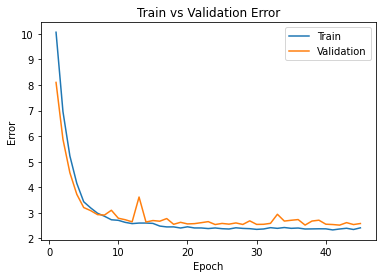

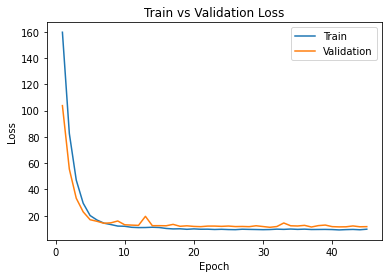

In [0]:
model_path = get_model_name("weatherSurrRNN", batch_size=30, learning_rate=0.01, epoch=45)

plot_training_curve(model_path)

In [0]:
class weatherSurrLSTM_ExtraLayer(nn.Module):

    def __init__(self, hidden_size = glob_inp_size, input_size = glob_inp_size, output_size = set_num_attributes, n_layers = 3): #,dropout=DROPOUT
        super(weatherSurrLSTM_ExtraLayer, self).__init__()
        self.name = "weatherSurrLSTM_ExtraLayer"
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True) # there is RNN, GRU, LSTM # dropout is NOT helpful in the LSTM
        self.fc1 = nn.Linear(hidden_size, hidden_size*10)
        self.fc2 = nn.Linear(hidden_size*10,  output_size)

    def forward(self, inp,  hidden = None):
        if(hidden == None):
          out, _ = self.rnn(inp)
        else:
          out, _ = self.rnn(inp, hidden)
        out = self.fc1(out[:, -1, :])
        out = F.leaky_relu(out) #tryleakyrelu
        out = self.fc2(out)


        return out

In [0]:
weatherSurrLSTM_ExtraLayer = weatherSurrLSTM_ExtraLayer(hidden_size=glob_inp_size)
if(use_cuda):
  weatherSurrLSTM_ExtraLayer = weatherSurrLSTM_ExtraLayer.cuda()
train(weatherSurrLSTM_ExtraLayer, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.01, num_epochs=45, master_path=master_path)

Training Started...
Epoch 1: Train err: 6.41382072777994, Train loss: 73.50104880659548 |Validation err: 4.05133288836235, Validation loss: 26.57420539855957
Epoch 2: Train err: 3.404607798949079, Train loss: 18.496011864649105 |Validation err: 3.6511132028307656, Validation loss: 19.536977688471477
Epoch 3: Train err: 2.713752111643211, Train loss: 11.811955602201698 |Validation err: 2.7824089861157555, Validation loss: 12.759754021962484
Epoch 4: Train err: 2.485655799667677, Train loss: 10.161720994400651 |Validation err: 2.5414648060359104, Validation loss: 11.019055843353271
Epoch 5: Train err: 2.4004145873723868, Train loss: 9.523313515806851 |Validation err: 2.4912935957978557, Validation loss: 10.696437338987986
Epoch 6: Train err: 2.4382023077744006, Train loss: 9.686869301208079 |Validation err: 2.5799286366729985, Validation loss: 10.905183951059977
Epoch 7: Train err: 2.323839594833866, Train loss: 9.006701626189768 |Validation err: 2.4940434037307115, Validation loss: 10.7

In [0]:
class weatherSurrLSTM_ExtraHidden(nn.Module):

    def __init__(self, hidden_size = glob_inp_size, input_size = glob_inp_size, output_size = set_num_attributes, n_layers = 3): #,dropout=DROPOUT
        super(weatherSurrLSTM_ExtraHidden, self).__init__()
        self.name = "weatherSurrLSTM_ExtraHidden"
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True) # there is RNN, GRU, LSTM # dropout is NOT helpful in the LSTM
        self.fc1 = nn.Linear(hidden_size, hidden_size*50)
        self.fc2 = nn.Linear(hidden_size*50,  output_size)

    def forward(self, inp,  hidden = None):
        if(hidden == None):
          out, _ = self.rnn(inp)
        else:
          out, _ = self.rnn(inp, hidden)
        out = self.fc1(out[:, -1, :])
        out = F.leaky_relu(out) #tryleakyrelu
        out = self.fc2(out)


        return out

In [0]:
weatherSurrLSTM_ExtraHidden = weatherSurrLSTM_ExtraHidden(hidden_size=glob_inp_size)
if(use_cuda):
  weatherSurrLSTM_ExtraHidden = weatherSurrLSTM_ExtraHidden.cuda()
train(weatherSurrLSTM_ExtraHidden, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.01, num_epochs=45, master_path=master_path)

Training Started...
Epoch 1: Train err: 5.1647507487816, Train loss: 48.413602267226125 |Validation err: 3.733366487437453, Validation loss: 21.8346905708313
Epoch 2: Train err: 3.0525336071134492, Train loss: 15.040597216723716 |Validation err: 2.7202727367647084, Validation loss: 12.384949207305908
Epoch 3: Train err: 2.6653227205476764, Train loss: 11.663250139314835 |Validation err: 2.6939452923983476, Validation loss: 12.135727524757385
Epoch 4: Train err: 2.510185605145019, Train loss: 10.343453289711313 |Validation err: 2.4823451302623027, Validation loss: 10.591433564821878
Epoch 5: Train err: 2.3972438271619914, Train loss: 9.466961044154756 |Validation err: 2.5801478291839164, Validation loss: 11.222831765810648
Epoch 6: Train err: 2.445846637609656, Train loss: 9.73449004186343 |Validation err: 2.5127589799977104, Validation loss: 10.470745841662088
Epoch 7: Train err: 2.428317543215351, Train loss: 9.76648239893456 |Validation err: 2.5199059711685976, Validation loss: 10.93